In [1]:
'''
Trying to understand how to use embedding over one hot
'''

'\nTrying to understand how to use embedding over one hot\n'

In [2]:
import pandas as pd
import torch
import gc
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [3]:

'''
Connect torch to processor
'''
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # Set the desired GPU (e.g., the first GPU)
    torch.cuda.set_device(0)
    print(f"Using GPU: {torch.cuda.current_device()} - {torch.cuda.get_device_name(torch.cuda.current_device())}")

    # Set device
    device = torch.device("cuda:0")

    print("Successful GPU connect")
else:
    device = torch.device('cpu')
    print("Using CPU")

GPU 0: NVIDIA GeForce MX150
Using GPU: 0 - NVIDIA GeForce MX150
Successful GPU connect


In [4]:
df = pd.read_csv(r"./lung_cancer_mortality_data_large.csv")
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Female,Germany,2016-04-05,Stage III,No,Never Smoked,31.1,257,1,1,0,0,Combined,2017-11-13,0
1,2,50.0,Male,Czech Republic,2023-04-20,Stage III,Yes,Passive Smoker,25.9,208,1,0,0,0,Radiation,2024-09-02,0
2,3,65.0,Male,Romania,2023-04-05,Stage IV,No,Never Smoked,18.9,193,0,0,0,0,Surgery,2024-10-08,0
3,4,51.0,Female,Latvia,2016-02-05,Stage III,Yes,Former Smoker,34.6,249,1,1,1,0,Surgery,2017-05-08,1
4,5,37.0,Male,Greece,2023-11-29,Stage I,Yes,Never Smoked,40.2,262,0,0,0,0,Chemotherapy,2025-05-03,0


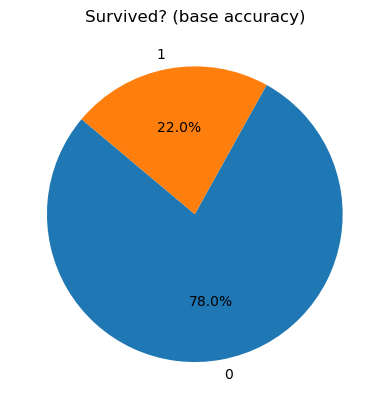

In [5]:
total_survival = df['survived'].value_counts()
plt.pie(total_survival, labels=total_survival.index, autopct='%1.1f%%', startangle=140)
plt.title('Survived? (base accuracy)')
plt.show()

In [6]:
# FIXME: Need to incorperate dates
try:
    df = df.drop(columns=['id', 'end_treatment_date', 'diagnosis_date'])
except KeyError:
    pass

# Binary
encoder = LabelEncoder()
df['family_history'] = encoder.fit_transform(df['family_history'])
df['gender'] = encoder.fit_transform(df['gender'])

# One hot
treatment_types = ['Radiation', 'Surgery', 'Chemotherapy']
for treatement in treatment_types:
    df[treatement] = 0

df.loc[df['treatment_type'] == 'Combined', treatment_types] = 1

for treatment in treatment_types:
    df.loc[df['treatment_type'] == treatment, treatment] = 1

df = df.drop(columns=['treatment_type'])

# Embedded
df['country_code'] = df['country'].astype('category').cat.codes
num_countries = len(df['country'].unique())
country_codes = torch.tensor(df['country_code'].values, dtype=torch.long)
df = df.drop(columns=['country'])

# Ordered (also embedded)
smoking_status_order = ['Never Smoked', 'Passive Smoker', 'Former Smoker', 'Current Smoker']
df['smoking_status'] = pd.Categorical(df['smoking_status'], categories=smoking_status_order, ordered=True)
df['smoking_status'] = df['smoking_status'].cat.codes
cancer_stage_order = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
df['cancer_stage'] = pd.Categorical(df['cancer_stage'], categories=cancer_stage_order, ordered=True)
df['cancer_stage'] = df['cancer_stage'].cat.codes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250000 entries, 0 to 3249999
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   age                float64
 1   gender             int32  
 2   cancer_stage       int8   
 3   family_history     int32  
 4   smoking_status     int8   
 5   bmi                float64
 6   cholesterol_level  int64  
 7   hypertension       int64  
 8   asthma             int64  
 9   cirrhosis          int64  
 10  other_cancer       int64  
 11  survived           int64  
 12  Radiation          int64  
 13  Surgery            int64  
 14  Chemotherapy       int64  
 15  country_code       int8   
dtypes: float64(2), int32(2), int64(9), int8(3)
memory usage: 306.8 MB


In [7]:
df.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,Radiation,Surgery,Chemotherapy,country_code
0,64.0,0,2,0,0,31.1,257,1,1,0,0,0,1,1,1,10
1,50.0,1,2,1,1,25.9,208,1,0,0,0,0,1,0,0,5
2,65.0,1,3,0,0,18.9,193,0,0,0,0,0,0,1,0,22
3,51.0,0,2,1,2,34.6,249,1,1,1,0,1,0,1,0,15
4,37.0,1,0,1,0,40.2,262,0,0,0,0,0,0,0,1,11


In [8]:
scaler = StandardScaler()
numerical_features = ['age', 'bmi', 'cholesterol_level']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,Radiation,Surgery,Chemotherapy,country_code
0,0.899921,0,2,0,0,0.072537,0.537704,1,1,0,0,0,1,1,1,10
1,-0.499908,1,2,1,1,-0.548619,-0.590068,1,0,0,0,0,1,0,0,5
2,0.999909,1,3,0,0,-1.384790,-0.935305,0,0,0,0,0,0,1,0,22
3,-0.399921,0,2,1,2,0.490622,0.353578,1,1,1,0,1,0,1,0,15
4,-1.799750,1,0,1,0,1.159559,0.652782,0,0,0,0,0,0,0,1,11


In [9]:
# Move 'survived' to end so the indices make scence after its droped
df = df[[c for c in df if c not in ['survived']] + ['survived']]

X = df.drop('survived', axis=1)
y = df['survived']

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

print(X.shape)

torch.Size([3250000, 15])


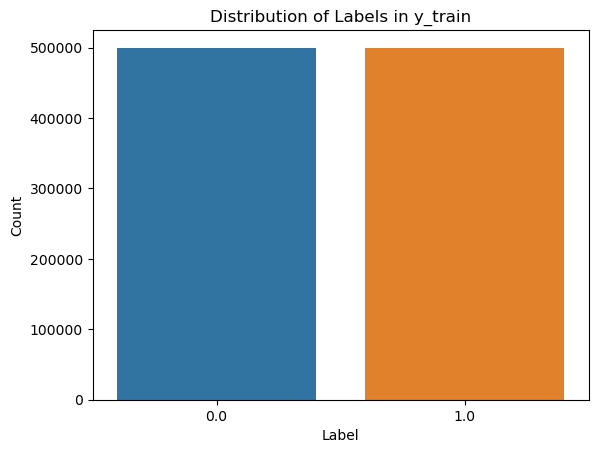

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

undersampler = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = undersampler.fit_resample(X_train.cpu().numpy(), y_train.cpu().numpy())

# Graphic
y_train_resampled_df = pd.DataFrame(y_train, columns=['label'])
sns.countplot(x='label', data=y_train_resampled_df)
plt.title('Distribution of Labels in y_train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

cat_indices = [df.columns.get_loc(col) for col in ['country_code', 'cancer_stage', 'smoking_status']]
num_indices = [i for i in range(X.shape[1]) if i not in cat_indices]

X_train_cat = X_train[:, cat_indices].long()
X_train_num = X_train[:, num_indices]

X_test_cat = X_test[:, cat_indices].long()
X_test_num = X_test[:, num_indices]

In [11]:
class Model(nn.Module):
    def __init__(self, num_countries, num_cancer_stages, num_smoking_statuses, embedding_dim, num_numerical_features):
        super(Model, self).__init__()
        # Embeddings. Cancer stage and smoking status could be one hot
        self.embedding_country = nn.Embedding(num_countries, embedding_dim)
        self.embedding_cancer_stage = nn.Embedding(num_cancer_stages, embedding_dim)
        self.embedding_smoking_status = nn.Embedding(num_smoking_statuses, embedding_dim)

        self.fc1 = nn.Linear(3 * embedding_dim + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_cat, x_num):
        x_country = self.embedding_country(x_cat[:, 0])
        x_cancer_stage = self.embedding_cancer_stage(x_cat[:, 1])
        x_smoking_status = self.embedding_smoking_status(x_cat[:, 2])
        
        x_cat_combined = torch.cat([x_country, x_cancer_stage, x_smoking_status], dim=1)
        
        x = torch.cat([x_cat_combined, x_num], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [12]:
num_countries = len(df['country_code'].unique())
num_cancer_stages = len(df['cancer_stage'].unique())
num_smoking_statuses = len(df['smoking_status'].unique())
embedding_dim = 10  # Wrong?
num_numerical_features = X.shape[1] - 3

mod = Model(num_countries, num_cancer_stages, num_smoking_statuses, embedding_dim, num_numerical_features)
mod.to(device)

# Move all data to GPU (Moving by batch was too slow)
X_train_cat = X_train_cat.to(device)
X_train_num = X_train_num.to(device)
y_train = y_train.to(device)

X_test_cat = X_test_cat.to(device)
X_test_num = X_test_num.to(device)
y_test = y_test.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mod.parameters(), lr=0.0001)

In [13]:
%%time

# Training loop
epochs = 10
for epoch in range(epochs):
    mod.train()
    optimizer.zero_grad()
    outputs = mod(X_train_cat, X_train_num)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [2/10], Loss: 0.6946
Epoch [4/10], Loss: 0.6943
Epoch [6/10], Loss: 0.6940
Epoch [8/10], Loss: 0.6938
Epoch [10/10], Loss: 0.6937
CPU times: total: 57.9 s
Wall time: 36.2 s


In [14]:
# Evaluate the model
mod.eval()
y_true = []
y_pred = []

with torch.no_grad():
    outputs = mod(X_test_cat, X_test_num)
    predicted = outputs.round()
    
    y_true = y_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5505
Precision: 0.2195
Recall: 0.4104
F1 Score: 0.2860


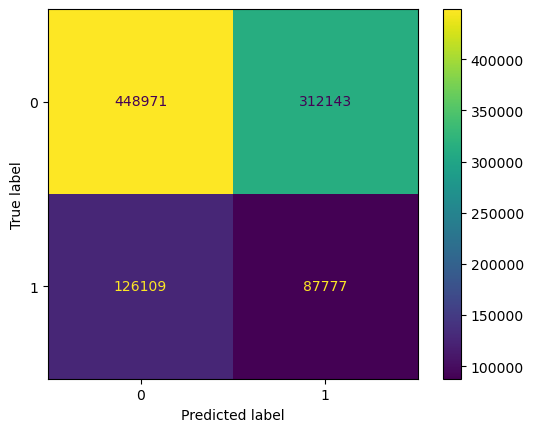

In [15]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [16]:
# Conditional so I can use run all without loosing the model
if False:
    # FIXME: Still not cleaning all memory for some reasion. RESTART KENEL TO CLEAR
    try:
        del mod 
        del X_train_cat, X_train_num, y_train
        del X_test_cat, X_test_num, y_test
    except NameError:
        pass

    # manually call because it is garbage collection is not working for GPU data
    gc.collect()
    torch.cuda.empty_cache()

    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)

    # print(torch.cuda.memory_summary(device=None, abbreviated=False))

    # print("Local variables:")
    # print(locals())
    # 
    # print("\nGlobal variables:")
    # print(globals())
